### Imports


In [2]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from lens_simulation import Lens, Simulation
from scipy import fftpack
from matplotlib import pyplot as plt

### Lens creation

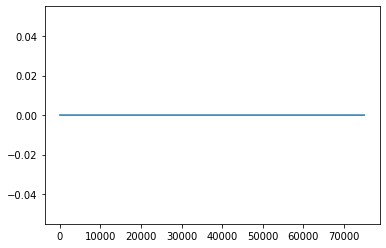

In [201]:
amplitude = 10000
sim_width = 1500e-6
pixel_size = 100e-9 
n_slices = 1000

lens_1 = Lens.Lens(
    diameter=sim_width,
    height=70e-6,
    exponent=0.,
    medium=Lens.Medium(2.348)
)
lens_1.generate_profile(pixel_size=pixel_size)
length = len(lens_1.profile)
lens_1.profile = np.pad(lens_1.profile, int(len(lens_1.profile)/0.5))
centre_px = (len(lens_1.profile)-1)//2

plt.plot(lens_1.profile)
plt.show()

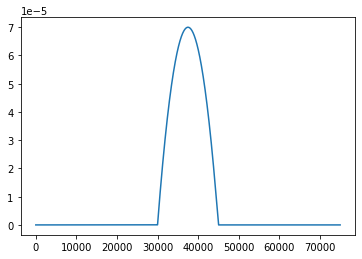

In [202]:
amplitude = 10000
sim_width = 1500e-6
pixel_size = 100e-9 

lens_2 = Lens.Lens(
    diameter=sim_width,
    height=70e-6,
    exponent=2.,
    medium=Lens.Medium(2.348)
)
lens_2.generate_profile(pixel_size=pixel_size)
lens_2.profile = np.pad(lens_2.profile, int(len(lens_2.profile)/0.5))

centre_px = (len(lens_2.profile)-1)//2

plt.plot(lens_2.profile)
plt.show()

### Simulation Parameters

In [203]:
A = 10000
output_medium_1 = Lens.Medium(2.348)
output_medium_2 = Lens.Medium(1.5)
sim_wavelength = 488e-9
step_size = 0.1e-6

### Simulation calculations

##### Lens 1

75005


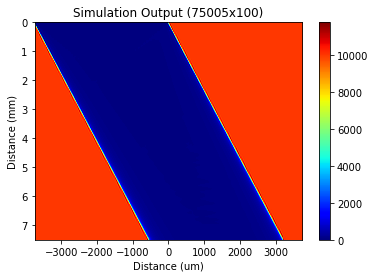

In [245]:
frequency_array_1 = Simulation.generate_squared_frequency_array(
    n_pixels=len(lens_1.profile), pixel_size=pixel_size)

print(len(frequency_array_1))

start_distance_1 = 0.
finish_distance_1 = len(lens_1.profile)*pixel_size#5.e-3

delta_1 = (lens_1.medium.refractive_index-output_medium_1.refractive_index) * lens_1.profile
phase_1 = (2 * np.pi * delta_1 / sim_wavelength) % (2 * np.pi)

# Angle of incoming illumination beam
theta_deg = 45
# # Must divide by 2 to have the output beam have angle theta
# theta_deg = theta_deg/2

# Aperturing the padding -> should be handled in Patrick's code
# cut = int((len(lens_1.profile)-length)/2)
cut = int((len(lens_1.profile)/2))
# # calculate shift to visualise but still have tilted beam hit at center
# shift = int((finish_distance_1-start_distance_1) * np.tan(np.deg2rad(theta_deg/2)) + length)
shift = 0
# from 0-> lens diameter
tilted_aranged = np.arange(len(lens_1.profile))*pixel_size

# Apply the phase delay that comes from tilted illumination
tilted_delta = tilted_aranged * np.sin(np.deg2rad(theta_deg*2)) 

# Calculate the phase, wavefront etc
phase_1 = (2 * np.pi * tilted_delta / sim_wavelength) % (2 * np.pi)
wavefront_1 = A * np.exp(1j * phase_1)

# Applying aperture 
wavefront_1[0:cut-shift] = 0 + 0j
# wavefront_1[-cut-shift:] = 0 + 0j

wavefront_1 = fftpack.fft(wavefront_1)

n_slices_1 = 100

sim_1 = np.ones(shape=((n_slices_1), len(lens_1.profile)))
distances_1 = np.linspace(start_distance_1, finish_distance_1, n_slices_1)
for i, z in enumerate(distances_1):
    prop_1 = np.exp(1j * output_medium_1.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_1) / output_medium_1.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_1 * wavefront_1)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_1[i] = np.round(output, 10)

from lens_simulation import utils
utils.plot_simulation(sim_1, sim_1.shape[1], sim_1.shape[0], pixel_size, start_distance_1, finish_distance_1)
# plt.imshow(sim)
plt.show()

# print(sim_1[0][centre_px-1])
# print(sim_1[0][centre_px])
# print(sim_1[0][centre_px+1])
# plt.plot(sim_1[0])
# plt.show()
# sim_1[sim_1 > 10000] = 0

# utils.plot_simulation(sim_1, sim_1.shape[1], sim_1.shape[0], pixel_size, start_distance_1, finish_distance_1)
# # plt.imshow(sim)
# plt.show()
passed_wavefront = propagation


#### Lens 2

75005


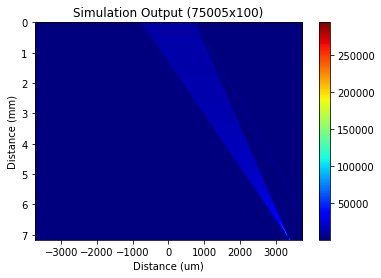

In [229]:
frequency_array_2 = Simulation.generate_squared_frequency_array(
    n_pixels=len(lens_2.profile), pixel_size=pixel_size)

print(len(frequency_array_2))

delta_2 = (lens_2.medium.refractive_index-output_medium_2.refractive_index) * lens_2.profile
phase_2 = (2 * np.pi * delta_2 / sim_wavelength) % (2 * np.pi)
wavefront_2 = 1 * np.exp(1j * phase_2) * passed_wavefront
fft_wavefront_2 = fftpack.fft(wavefront_2)

equivalent_focal_distance_2 = Simulation.calculate_equivalent_focal_distance(lens_2, output_medium_2)
start_distance_2 = 0 * equivalent_focal_distance_2
finish_distance_2 = 1 * equivalent_focal_distance_2

n_slices_2 = 100

sim_2 = np.ones(shape=((n_slices_2), len(lens_2.profile)))
distances_2 = np.linspace(start_distance_2, finish_distance_2, n_slices_2)
for i, z in enumerate(distances_2):
    prop_2 = np.exp(1j * output_medium_2.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_2) / output_medium_2.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_2 * fft_wavefront_2)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_2[i] = np.round(output, 10)

passed_wavefront = propagation

from lens_simulation import utils
utils.plot_simulation(sim_2, sim_2.shape[1], sim_2.shape[0], pixel_size, start_distance_2, finish_distance_2)
# plt.imshow(sim)
plt.show()


75005


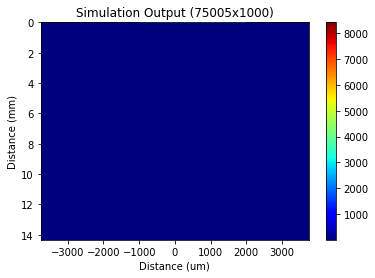

In [213]:
frequency_array_2 = Simulation.generate_squared_frequency_array(
    n_pixels=len(lens_2.profile), pixel_size=pixel_size)

print(len(frequency_array_2))

delta_2 = (lens_2.medium.refractive_index-output_medium_2.refractive_index) * lens_2.profile
phase_2 = (2 * np.pi * delta_2 / sim_wavelength) % (2 * np.pi)
wavefront_2 = 1 * np.exp(1j * phase_2) * passed_wavefront
fft_wavefront_2 = fftpack.fft(wavefront_2)

equivalent_focal_distance_2 = Simulation.calculate_equivalent_focal_distance(lens_2, output_medium_2)
start_distance_2 = 0 * equivalent_focal_distance_2
finish_distance_2 = 2 * equivalent_focal_distance_2

n_slices_2 = 1000

sim_2 = np.ones(shape=((n_slices_2), len(lens_2.profile)))
distances_2 = np.linspace(start_distance_2, finish_distance_2, n_slices_2)
for i, z in enumerate(distances_2[-3:-1]):
    prop_2 = np.exp(1j * output_medium_2.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_2) / output_medium_2.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_2 * fft_wavefront_2)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_2[i] = np.round(output, 10)

passed_wavefront = propagation

from lens_simulation import utils
utils.plot_simulation(sim_2, sim_2.shape[1], sim_2.shape[0], pixel_size, start_distance_2, finish_distance_2)
# plt.imshow(sim)
plt.show()


4501


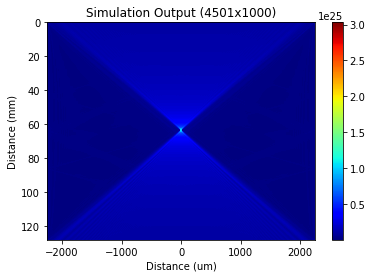

In [20]:
frequency_array_2 = Simulation.generate_squared_frequency_array(
    n_pixels=len(lens_2.profile), pixel_size=pixel_size)

print(len(frequency_array_2))

delta_2 = (lens_2.medium.refractive_index-output_medium_2.refractive_index) * lens_2.profile
phase_2 = (2 * np.pi * delta_2 / sim_wavelength) % (2 * np.pi)
wavefront_2 = A * np.exp(1j * phase_2) * passed_wavefront
fft_wavefront_2 = fftpack.fft(wavefront_2)

equivalent_focal_distance_2 = Simulation.calculate_equivalent_focal_distance(lens_2, output_medium_2)
start_distance_2 = 0 * equivalent_focal_distance_2
finish_distance_2 = 2 * equivalent_focal_distance_2

n_slices_2 = 1000

sim_2 = np.ones(shape=((n_slices_2), len(lens_2.profile)))
distances_2 = np.linspace(start_distance_2, finish_distance_2, n_slices_2)
for i, z in enumerate(distances_2):
    prop_2 = np.exp(1j * output_medium_2.wave_number * z) * np.exp(
        (-1j * 2 * np.pi ** 2 * z * frequency_array_2) / output_medium_2.wave_number
    )
    # print("prop shape: ", prop.shape)
    propagation = fftpack.ifft(prop_2 * fft_wavefront_2)

    output = np.sqrt(propagation.real ** 2 + propagation.imag ** 2)

    sim_2[i] = np.round(output, 10)

passed_wavefront = propagation

from lens_simulation import utils
utils.plot_simulation(sim_2, sim_2.shape[1], sim_2.shape[0], pixel_size, start_distance_2, finish_distance_2)
# plt.imshow(sim)
plt.show()
